# Step by step
This notebook replicates the code on the 'functions' page, offering insight into the inner workings of the functions. This allows anyone interested in comprehending and modifying the code to gain a general understanding.

In [1]:
import pandas as pd
from models_classifier import generate_model
import matplotlib.pyplot as plt
from xgboost import plot_importance
import shap
from functions import feature_importance
from preprocessing import split_df
import re
from IPython.display import Image

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Preprocessing

Load data

In [2]:
# Imports excell with patients data
data_path = "./data/New_Dummy_Data.xlsx"
sheet_names = ['Baseline', 'TEG Values', 'Events']  # Replace with your sheet names
data_frames = pd.read_excel(data_path, sheet_name=sheet_names)

# Access each sheet's data using the sheet name as the key
baseline_df = data_frames[sheet_names[0]]
tegValues_df = data_frames[sheet_names[1]]
events_df = data_frames[sheet_names[2]]

In [3]:
baseline_df.head()

,Record ID,Age,Sex,White,Extremity,Artery affected,BMI,"Tobacco Use (1 current 2 former, 3 none)",Diabetes,Hypertension,...,Hx of pulmonary embolism,Does the patient have a history of solid organ transplant?,EGFR (mL/min/1.73m2),Has subject had previous intervention of the index limb?,Previous occluded stents,Rutherford Score,ABI Right,ABI left,Intervention Classification,Intervention Type
0,190,86.303872,Male,0,left,"common femoral, popliteal, posterior tibial, a...",19.694747,quit 1 to 10 years ago,0,1,...,No,Yes,>60,0,0,3.121249,1.104434,0.887543,Combined,"angioplasty, endarterectomy, bypass"
1,49,79.695236,Male,0,Bilateral,anterior tibial,16.461134,current within the last year ( > or = 1 pack ...,0,0,...,No,Yes,53.26246,0,0,1.800103,0.878669,1.602686,Open,"angioplasty, stent, endarterectomy"
2,143,70.149430,Female,1,right,"SFA, external iliac, internal iliac",39.511517,"Past, quit >10 year ago",1,1,...,No,Yes,53.557591,0,0,3.849625,1.287332,0.166172,Endo,DVA
3,35,78.958690,Female,0,Bilateral,"common femoral, anterior tibial, posterior tibial",16.369186,quit 1 to 10 years ago,1,1,...,Yes,Yes,46.661895,0,0,5.777198,0.439484,0.284048,Endo,"angioplasty, stent"
4,6,83.272199,Male,0,Bilateral,"SFA, posterior tibial, external iliac",35.443487,"Past, quit >10 year ago",0,1,...,No,Yes,58.637421,0,0,3.400018,0.568569,not done,Endo,DVA


In [4]:
tegValues_df.head()

,Record ID,Visit Timepoint,Antiplatelet Therapy within 7 Days,Anticoagulation within 24 Hours,Statin within 24 Hours,Cilostazol within 7 days,BP prior to blood draw_left,BP prior to blood draw_right,Reaction Time (R) in min,Lysis at 30 min (LY30) in %,...,CFF FLEV(mg/dL),HbA1c Baseline( within1 year of study start),INR value,aPTT,PT value,WBC in K/uL,RBC (M/uL),HGB(g/dL),HCT %,PLT(K/uL)
0,13,Readmission,"aspirin, ticagrelor","enoxaprin, heparin",atorvastatin,cilostazol,115.594165,46.193358,2.912198,2.303005,...,894.557223,6.195647,204.709943,108.842874,33.304108,8.588486,5.549346,8.884997,43.564458,411.527514
1,137,30 Day Post Procedure,"aspirin, clopidogrel","enoxaprin, heparin",Rosuvastatin,NaN,165.002657,80.882581,15.692453,1.306809,...,441.491137,8.894708,219.669077,41.791884,18.994177,14.045750,5.648294,8.231149,37.166152,105.318678
2,91,Enrollment + Baseline,ticagrelor,heparin,Pravastatin,cilostazol,174.21663,98.482372,5.377799,10.083777,...,1311.836495,6.484305,139.095719,43.586576,36.699635,7.092247,5.945021,15.073190,26.574302,78.595207
3,101,Readmission,"clopidogrel, celecoxib","heparin, rivaroxaban",atorvastatin,NaN,156.161237,136.963391,14.345477,*,...,*,10.147413,142.472389,72.515587,38.558471,5.131052,5.433696,18.689851,42.671977,606.890259
4,121,3M PO,"aspirin, ticagrelor","enoxaprin, warfarin",Lovastatin,NaN,149.124416,191.606004,7.472077,15.405954,...,760.412575,11.006822,93.518325,27.730606,38.627417,10.655076,6.102320,17.428863,23.647454,184.050455


In [5]:
events_df.head()

,Record ID,Event Name,Date of Event,Event Type
0,T21-35,Event reporting 4,355.738509,Infection/Dehiscence
1,124,Event reporting 4,28.451735,Occlusion in the area of intervention
2,168,Event Reporting 1,88.733783,Worsening/enlarging wound
3,73,Event reporting 6,388.572455,Thrombotic event not related to stent
4,T21-9,Readmission 2,475.579295,Bypass/Stent stenosis


### Merge tables
The data has the following shape

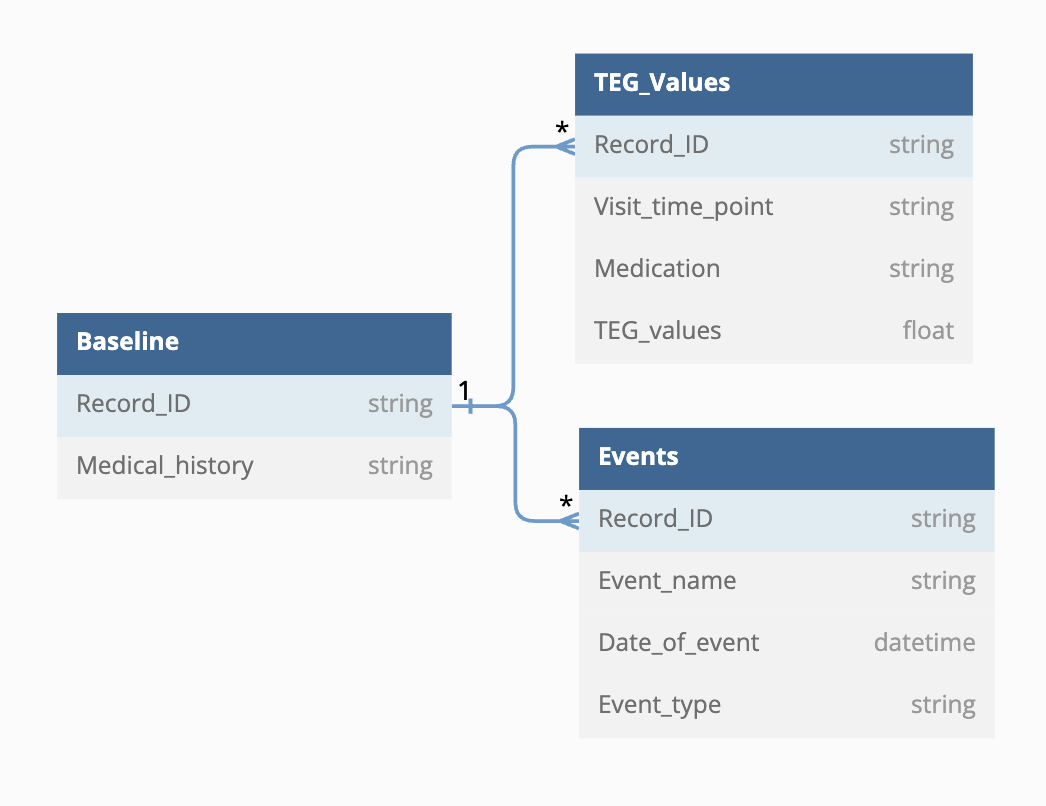

In [6]:
# Path to image
image_path = "./data/data_structure.png"
# Display the image
display(Image(filename=image_path, width=300, height=200))


The model will only take one database so they will all be merged.
The information from baseline will be copied to TEG_values.
Every patient that has an event will be marked like as risk of thrombosis in a new column called "Had event"

In [11]:
merged_df = baseline_df.merge(tegValues_df, on='Record ID', how='inner')
merged_df

,Record ID,Age,Sex,White,Extremity,Artery affected,BMI,"Tobacco Use (1 current 2 former, 3 none)",Diabetes,Hypertension,...,CFF FLEV(mg/dL),HbA1c Baseline( within1 year of study start),INR value,aPTT,PT value,WBC in K/uL,RBC (M/uL),HGB(g/dL),HCT %,PLT(K/uL)
0,190,86.303872,Male,0,left,"common femoral, popliteal, posterior tibial, a...",19.694747,quit 1 to 10 years ago,0,1,...,1834.184238,9.708764,135.961732,89.815195,16.545174,24.886623,3.483423,9.769612,46.578249,189.436163
1,190,86.303872,Male,0,left,"common femoral, popliteal, posterior tibial, a...",19.694747,quit 1 to 10 years ago,0,1,...,2065.501597,9.482384,12.823844,96.250259,3.197857,21.706698,4.553367,12.141345,44.302995,318.427137
2,190,86.303872,Male,0,left,"common femoral, popliteal, posterior tibial, a...",19.694747,quit 1 to 10 years ago,0,1,...,2055.831865,6.792513,177.094725,83.683092,2.066636,12.108086,3.835093,8.168005,31.420818,553.937860
3,190,86.303872,Male,0,left,"common femoral, popliteal, posterior tibial, a...",19.694747,quit 1 to 10 years ago,0,1,...,476/3,6.509117,133.293015,42.983323,35.881350,20.774759,2.607172,17.071911,55.222059,177.798347
4,190,86.303872,Male,0,left,"common femoral, popliteal, posterior tibial, a...",19.694747,quit 1 to 10 years ago,0,1,...,1684.315305,8.536745,228.522382,77.190557,11.448507,6.318149,5.070032,16.205421,35.454810,342.708486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,36,90.231095,Female,1,Bilateral,"common femoral, SFA, popliteal, anterior tibia...",33.755773,current within the last year ( > or = 1 pack ...,1,0,...,601.046494,5.216795,172.800259,56.645717,7.079594,21.059502,4.957063,14.753277,38.675215,281.832193
276,94,76.176282,Female,0,left,"SFA, popliteal, aortoiliac",26.893103,quit 1 to 10 years ago,0,1,...,2100.737144,8.025082,101.052358,>150,25.886146,17.480209,4.612372,17.412170,32.121853,544.538660
277,94,76.176282,Female,0,left,"SFA, popliteal, aortoiliac",26.893103,quit 1 to 10 years ago,0,1,...,1020.997866,7.535807,35.886463,49.90025,8.100417,13.643922,2.652882,14.406773,45.856872,258.054788
278,94,76.176282,Female,0,left,"SFA, popliteal, aortoiliac",26.893103,quit 1 to 10 years ago,0,1,...,1869.260566,5.959770,229.347569,124.472073,11.738846,13.159509,3.668246,11.381949,37.828476,597.049521


In [ ]:
# Assuming your dataframes are named 'baseline_df', 'tegValues_df', and 'events_df'
# Merge baseline_df and tegValues_df based on 'Record_ID'
merged_df = tegValues_df.merge(baseline_df[['Record_ID', 'comorbidities']], on='Record_ID', how='left')

# Count the number of events for each 'Record_ID' in events_df
event_counts = events_df['Record_ID'].value_counts().reset_index()
event_counts.columns = ['Record_ID', 'event_count']

# Merge the event counts with the merged_df
merged_df = merged_df.merge(event_counts, on='Record_ID', how='left')

# Fill NaN values in the 'event_count' column with 0
merged_df['event_count'].fillna(0, inplace=True)

# Display the resulting dataframe
print(merged_df)






## Train model

In [ ]:
data_path = "./data/Preprocessed_Data.xlsx"
df = pd.read_excel(data_path)
df

In [ ]:
# Make models to find contribution of each parameter
best_model, best_params, accuracy, X_train = generate_model(df)


In [ ]:
model = best_model.named_steps['classifier']
scaler = best_model.named_steps['scaler']
model

In [ ]:
# Get feature importances from the XGBoost model in the pipeline
feature_importance_df = feature_importance(best_model, X_train)
feature_importance_df

In [ ]:
output_file = './data/Feature_importance.xlsx'
feature_importance_df.to_excel(output_file, index=False)


In [ ]:
# Create a DataFrame with the features related to TEG values
teg_df , non_teg_df = split_df(feature_importance_df)
teg_df

In [ ]:
non_teg_df

In [ ]:
# Select only the other features and the ones selected by user
selected_features = {
"Clot treatment drugs":"HKH MA (mm) (3.6591007709503174%)",
"Effects of fibrogen":"ActF MA (mm) (1.9013619422912598%)",
"Heparin effect":"HKH MA (mm) (3.6591007709503174%)",
"Unaltered blood ":"CK MA (mm)_difference_since_last_timepoint (0.0%)",
"Unaltered time to clot ":"CK R (min) (1.8973780870437622%)",
}


In [ ]:
selected_features_list = []

# Process the values in the dictionary
for key, value in selected_features.items():
    # Remove patterns matching (float%)
    selected_features_list.append(re.sub(r'\(\d+\.\d+%\)', '', value).strip())
selected_features_list

In [ ]:
# Extract the features mentioned in the "Feature" column of non_teg_df
non_teg_features = non_teg_df['Feature'].tolist()
selected_features_list =  selected_features_list + non_teg_features
selected_features_list

In [ ]:
# Filter the columns of the original DataFrame based on the selected features
filtered_df = df[selected_features_list]
filtered_df